## Ebola infected Macaque Sample Composition Trajectory Identification

In this notebook we deconvolve the ebov macaque blood samples using a matched seq-well reference.

In [1]:
import torch
from time_deconv.time_deconv import *
from time_deconv.time_deconv_simulator import *
from time_deconv.stats_helpers import *

# Configuration

In [2]:
device = torch.device("cuda:0")
dtype = torch.float32
dtype_np = np.float32

# Load data

In [3]:
bulk_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_bulk.h5ad"
sc_anndata_path = "/home/nbarkas/disk2/deconvolution_method/datasets/ebov/load_data_python/ebov_sc.h5ad"

In [4]:
with open(bulk_anndata_path, 'rb') as fh:
    bulk_anndata  = anndata.read_h5ad(fh)
with open(sc_anndata_path, 'rb') as fh:
    sc_anndata = anndata.read_h5ad(fh)

In [5]:
# select samples only after or on tp 0
bulk_anndata = bulk_anndata[bulk_anndata.obs['dpi_time'] >= 0,]

In [6]:
ebov_dataset = DeconvolutionDataset(
    sc_anndata = sc_anndata,
    sc_celltype_col = "Subclustering_reduced",
    bulk_anndata = bulk_anndata,
    bulk_time_col = "dpi_time",
    dtype_np = dtype_np,
    dtype = dtype,
    device=device,
    feature_selection_method = 'single_cell_od' #'overdispersed_bulk'
)

# Run Deconvolution

In [7]:
pseudo_time_reg_deconv = TimeRegularizedDeconvolution(
    dataset=ebov_dataset,
    polynomial_degree = 10,
    basis_functions = "polynomial",
    device=device,
    dtype=dtype)

In [8]:
batch = generate_batch(pseudo_time_reg_deconv.dataset, device, dtype)
c = torch.nn.functional.softmax(torch.rand([10,5]), dim=-1)
pseudo_time_reg_deconv.model(**batch)

In [9]:
pseudo_time_reg_deconv.fit_model(n_iters=10_000, verbose=True, log_frequency=1000, clear_param_store=True)

[iteration: 0]   loss: 8915710.66
[iteration: 1000]   loss: 2792500.75
[iteration: 2000]   loss: 1284594.15
[iteration: 3000]   loss: 803585.95
[iteration: 4000]   loss: 625652.37
[iteration: 5000]   loss: 545390.81
[iteration: 6000]   loss: 504091.97
[iteration: 7000]   loss: 481591.65
[iteration: 8000]   loss: 469066.28
[iteration: 9000]   loss: 462088.95


# Examine Outputs

<AxesSubplot:title={'center':'Losses'}, xlabel='iteration', ylabel='ELBO Loss'>

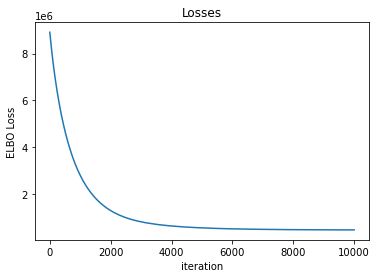

In [10]:
# Plot the loses
pseudo_time_reg_deconv.plot_loss()

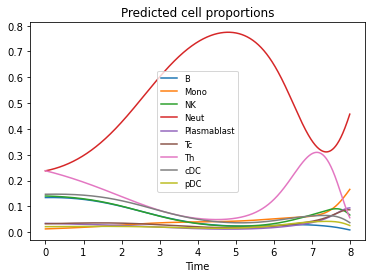

In [11]:
# calculate and plot the composition trajectories
pseudo_time_reg_deconv.calculate_composition_trajectories(n_intervals = 1000)
pseudo_time_reg_deconv.plot_composition_trajectories()

<AxesSubplot:xlabel='$\\phi_g$', ylabel='Counts'>

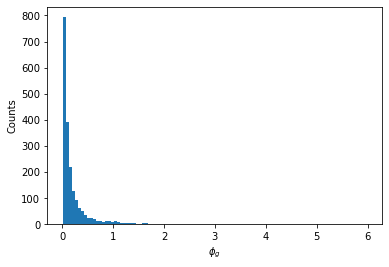

In [12]:
# examine the per-gene dispersions
pseudo_time_reg_deconv.plot_phi_g_distribution()

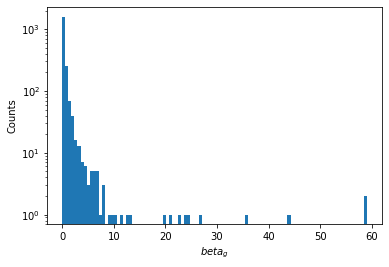

In [13]:
# examine the gene capture coefficients
pseudo_time_reg_deconv.plot_beta_g_distribution()
matplotlib.pyplot.yscale('log')

Text(0.5, 1.0, 'Last few Dirichlet $ \\alpha $ Values')

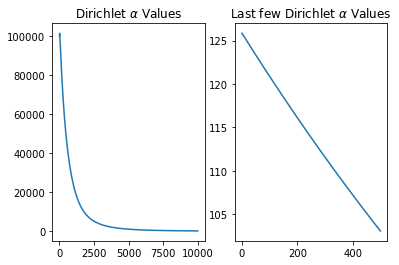

In [14]:
# examine the alphas

alphas = list(pseudo_time_reg_deconv.param_store_hist[i]['dirichlet_alpha'] for i in range(len(pseudo_time_reg_deconv.param_store_hist)))

fig, ax = matplotlib.pyplot.subplots(1,2)

ax[0].plot(alphas)
ax[0].set_title(r'Dirichlet $ \alpha $ Values')

ax[1].plot(alphas[-500:])
ax[1].set_title(r'Last few Dirichlet $ \alpha $ Values')


array([[<AxesSubplot:title={'center':'B'}>,
        <AxesSubplot:title={'center':'Neut'}>,
        <AxesSubplot:title={'center':'Th'}>],
       [<AxesSubplot:title={'center':'Mono'}>,
        <AxesSubplot:title={'center':'Plasmablast'}>,
        <AxesSubplot:title={'center':'cDC'}>],
       [<AxesSubplot:title={'center':'NK'}>,
        <AxesSubplot:title={'center':'Tc'}>,
        <AxesSubplot:title={'center':'pDC'}>]], dtype=object)

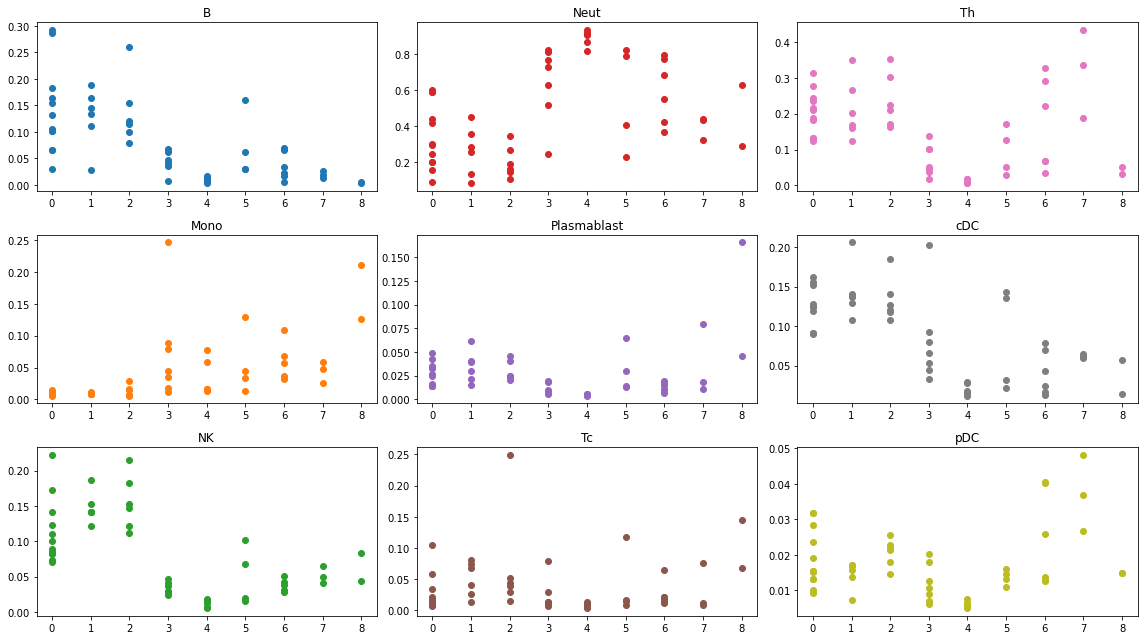

In [16]:
pseudo_time_reg_deconv.plot_sample_compositions_scatter()

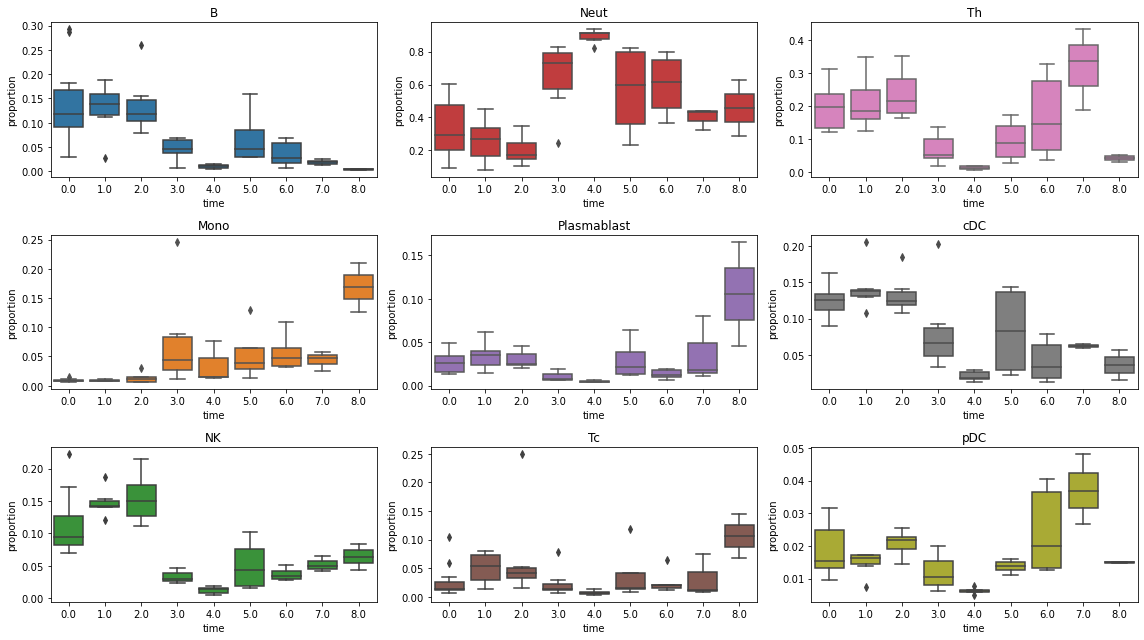

In [15]:
pseudo_time_reg_deconv.plot_sample_compositions_boxplot()
matplotlib.pyplot.show()